# Settings

In [1]:
! pip install music21
! pip install mido
! pip install pitchscapes -U
# ! pip install folium==0.2.1
# ! pip install Sphinx==3.0
! pip install pykeops[full] > install.log

Requirement already up-to-date: pitchscapes in /usr/local/lib/python3.6/dist-packages (0.1.5)


In [2]:
# ! wget -O scores.zip https://www.dropbox.com/s/9tzzrb8j34y65y2/scores.zip?dl=0
# ! unzip scores.zip

In [3]:
! wget -O slice_data.pt https://www.dropbox.com/s/wv3tsrlidamp7zm/alex_data.pt?dl=0

--2020-11-14 14:02:40--  https://www.dropbox.com/s/wv3tsrlidamp7zm/alex_data.pt?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.1, 2620:100:6016:1::a27d:101
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/wv3tsrlidamp7zm/alex_data.pt [following]
--2020-11-14 14:02:40--  https://www.dropbox.com/s/raw/wv3tsrlidamp7zm/alex_data.pt
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc6398accf32565ea8c2cfd85163.dl.dropboxusercontent.com/cd/0/inline/BDIjm6WvLEtFmv-FV1TXlPVFG3t8QvpuD-rZKJJRQ8e4QU60h4OAzqUf3RABY-bDW-8QGzJwh2SOkOmqbrEKX3OGwjErw2WG_aAzSYXmwJ4dDKxoTHPJ5xIakHo-4sc9mlg/file# [following]
--2020-11-14 14:02:41--  https://uc6398accf32565ea8c2cfd85163.dl.dropboxusercontent.com/cd/0/inline/BDIjm6WvLEtFmv-FV1TXlPVFG3t8QvpuD-rZKJJRQ8e4QU60h4OAzqUf3RABY-bDW-8QGzJwh2SOkOmqbrEKX3OGwjErw2WG_aAzSYXmwJ4dD

# Main block

In [4]:
import matplotlib.cm as cm
import numpy as np
import torch
from matplotlib import pyplot as plt
from torch.nn import Module, Parameter
from torch.nn.functional import softmax, log_softmax
from itertools import product
import numpy as np
import matplotlib.pyplot as plt
import pitchscapes.reader as rd
import pitchscapes.plotting as pt
import os
from pykeops.torch import Kernel, kernel_product
from sklearn.manifold import Isomap
import plotly.express as px
from IPython.display import HTML
import pandas as pd
%matplotlib inline

In [5]:
dtype = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor

In [6]:
def prepare_data(data_dir = 'scores/Bach_JohannSebastian', n_times= 10, number_of_features = 12, number_of_files = 130):
    # read the score into a pitch scape
    data_points_per_scape = int(n_times * (n_times - 1) / 2)
    cnt = 0

    data = torch.zeros((data_points_per_scape * number_of_files, number_of_features))
    for r, d, f in os.walk(data_dir):
        for file in f:
            try:
                pitch_scape = rd.get_pitch_scape(os.path.join(r, file))
                times = np.linspace(pitch_scape.min_time, pitch_scape.max_time, n_times)
                for start, end in product(times, times):
                    if end <= start:
                        continue
                    data_point = np.array(pitch_scape[start, end])
                    data_point /= data_point.sum()
                    data[cnt] = torch.tensor(data_point).type(dtype).reshape(1,-1)
                    cnt += 1  
            except:
                continue
    data.requires_grad = True
    return data.type(dtype)

# GMM Model

In [7]:
class GaussianMixture(Module):
    def __init__(self, M, sparsity=0, D=2):
        super(GaussianMixture, self).__init__()
        
        self.params = {'id': Kernel('gaussian(x,y)')}
        # We initialize our model with random blobs scattered across
        # the unit square, with a small-ish radius:
        self.mu = Parameter(torch.rand(M, D).type(dtype))
        self.A = torch.ones(M, 1, 1) * torch.eye(D, D).view(1, D, D) + 0.5 * np.identity(D)
        self.A = Parameter((self.A).type(dtype))
        self.w = Parameter(torch.ones(M, 1).type(dtype))
        self.sparsity = sparsity
    
    
    def update_covariances(self):
        """Computes the full covariance matrices from the model's parameters."""
        (M, D, _) = self.A.shape
        #self.params['gamma'] = (torch.matmul(self.A, self.A.transpose(1, 2))).view(M, D, D) / 2
        self.params['gamma'] = (torch.matmul(self.A, self.A.transpose(1, 2))).view(M, D * D) / 2
    
    
    def covariances_determinants(self):
        """Computes the determinants of the covariance matrices.
        
        N.B.: PyTorch still doesn't support batched determinants, so we have to
              implement this formula by hand.
        """
        S = self.params['gamma']
        D = int(S.shape[1]**0.5)
        dets = torch.det(S.reshape(-1, D, D)) 
        return dets.view(-1, 1)
    
    
    def weights(self):
        """Scalar factor in front of the exponential, in the density formula."""
        return softmax(self.w, 0) * self.covariances_determinants().sqrt()
    
    
    def weights_log(self):
        """Logarithm of the scalar factor, in front of the exponential."""
        return log_softmax(self.w, 0) + .5 * self.covariances_determinants().log()
    
    
    def likelihoods(self, sample):
        """Samples the density on a given point cloud."""
        self.update_covariances()
        return kernel_product(self.params, sample, self.mu, self.weights(), mode='sum')
    
    
    def log_likelihoods(self, sample):
        """Log-density, sampled on a given point cloud."""
        self.update_covariances()
        return kernel_product(self.params, sample, self.mu, self.weights_log(), mode='lse')
    
    
    def neglog_likelihood(self, sample):
        """Returns -log(likelihood(sample)) up to an additive factor."""
        ll = self.log_likelihoods(sample)
        log_likelihood = torch.mean(ll)
        # N.B.: We add a custom sparsity prior, which promotes empty clusters
        #       through a soft, concave penalization on the class weights.
        return -log_likelihood + self.sparsity * softmax(self.w, 0).sqrt().mean()
    
    
    def get_sample(self, N):
        """Generates a sample of N points."""
        raise NotImplementedError()
    
    def predict(self, sample):
        (num_clusters, D, _) = self.A.shape
        log_prob = torch.zeros((sample.shape[0], num_clusters))
        Cov = (torch.matmul(self.A, self.A.transpose(1, 2))).view(num_clusters, D, D) / 2
        # for i in range(sample.shape[0]):
        #     for j in range(num_clusters):
        #         dif = sample[i]-self.mu[j]
        #         log_prob[i, j] = log_softmax(self.w, 0)[j] + .5 * self.covariances_determinants().log()[j] - torch.matmul(torch.matmul(dif, Cov[j]), dif) 
        for j in range(num_clusters):
           dif = sample-self.mu[j]
            #torch.dot(torch.dot(dif, Cov[j]), dif).shape
            #print(dif.shape, Cov[j].shape, torch.matmul(dif, Cov[j]))
            #np.sum(np.multiply(np.dot(X-mean, np.linalg.inv(sigma)),(X-mean)))
           log_prob[:, j] = log_softmax(self.w, 0)[j] + .5 * self.covariances_determinants().log()[j] - torch.sum(torch.multiply(torch.matmul(dif, Cov[j]), dif), axis = 1)#torch.matmul(torch.matmul(dif, Cov[j]), dif.T) 
        label = torch.argmax(log_prob, dim=1)
        return label

    def plot_clusters(self, sample, dims=2):
        """Displays the model."""
        labels = self.predict(sample)
        fig = plt.figure(figsize=(15, 8))
        embedding = Isomap(n_components=dims)
        X = sample.detach().cpu().numpy()
        X = embedding.fit_transform(X)
        labels = labels.detach().cpu().numpy()#.reshape((labels.shape[0], 1))
        #plt.scatter(X[:, 0], c=labels, cmap=plt.cm.Spectral)
        if dims == 2:
          plt.scatter(X[:, 0], X[:, 1], c=labels, cmap=plt.cm.Spectral)
          plt.show()
        else:
          df = pd.DataFrame({'cluster':labels, 'x':X[:, 0], 'y':X[:, 1], 'z':X[:, 2]})
          fig = px.scatter_3d(df, x='x', y='y', z='z', color='cluster')
          fig.show()


# Training loop

In [12]:
data = torch.load('slice_data.pt').type(dtype)
# data = data[torch.randperm(data.shape[0])]
# data.requires_grad = True

In [13]:
data.shape[0] / 4 / 7

3113.0

<Figure size 576x576 with 0 Axes>

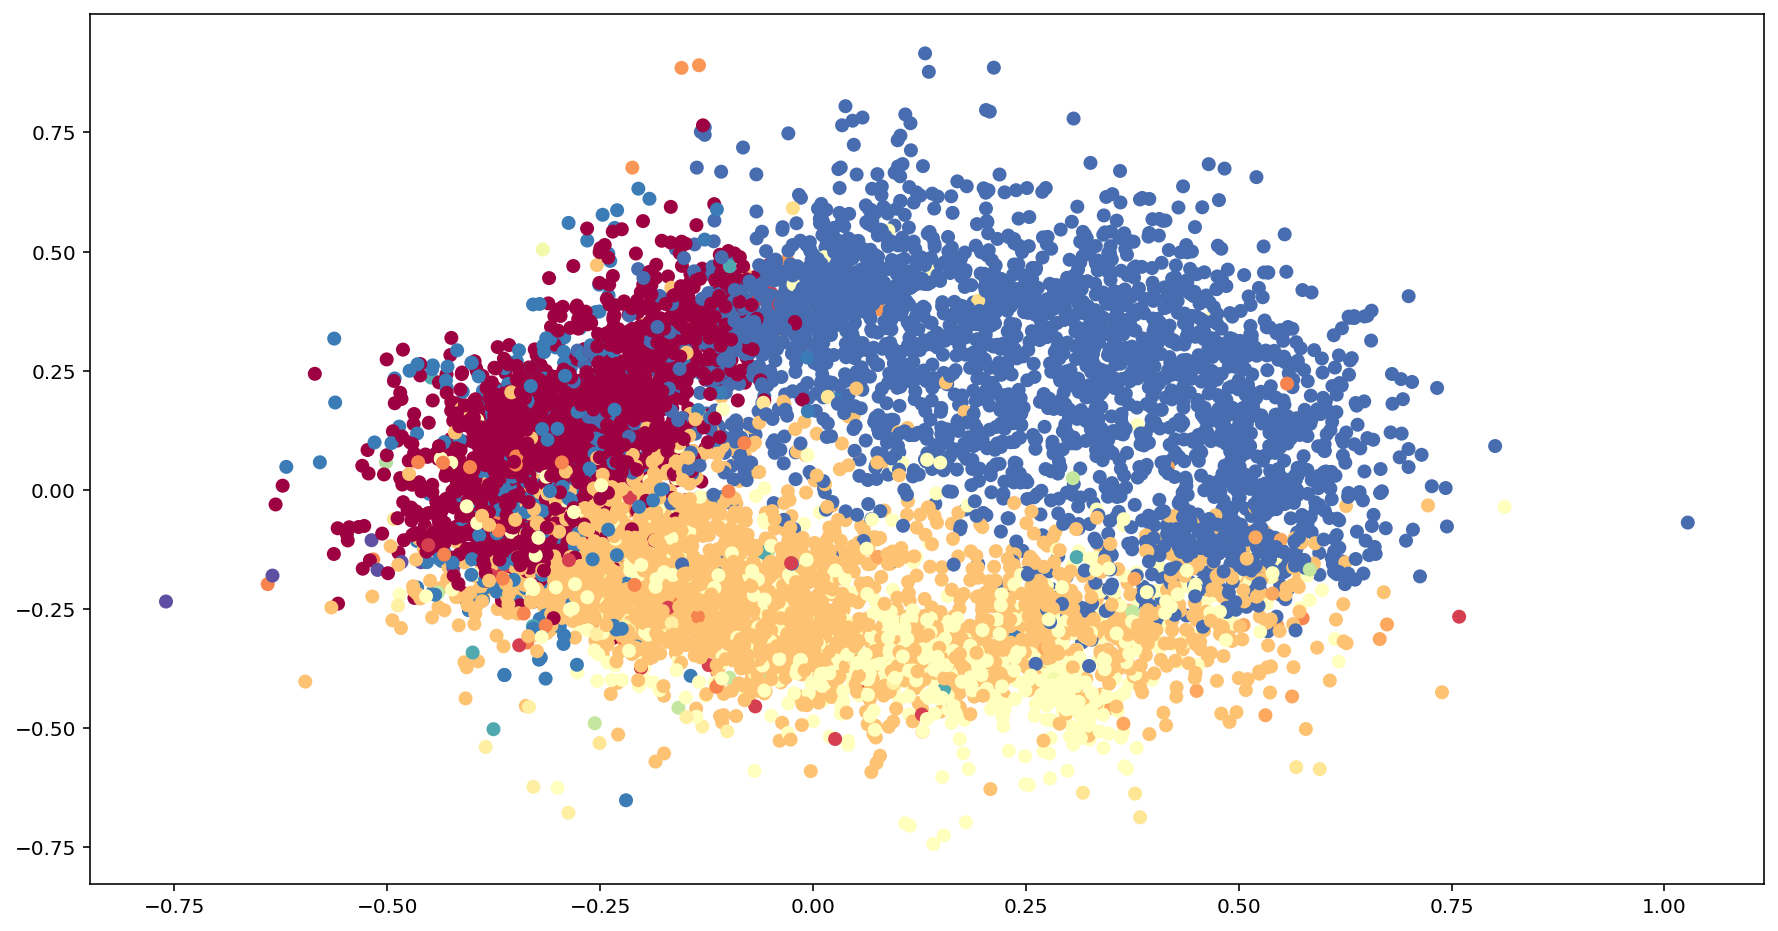

<Figure size 432x288 with 0 Axes>

<Figure size 576x576 with 0 Axes>

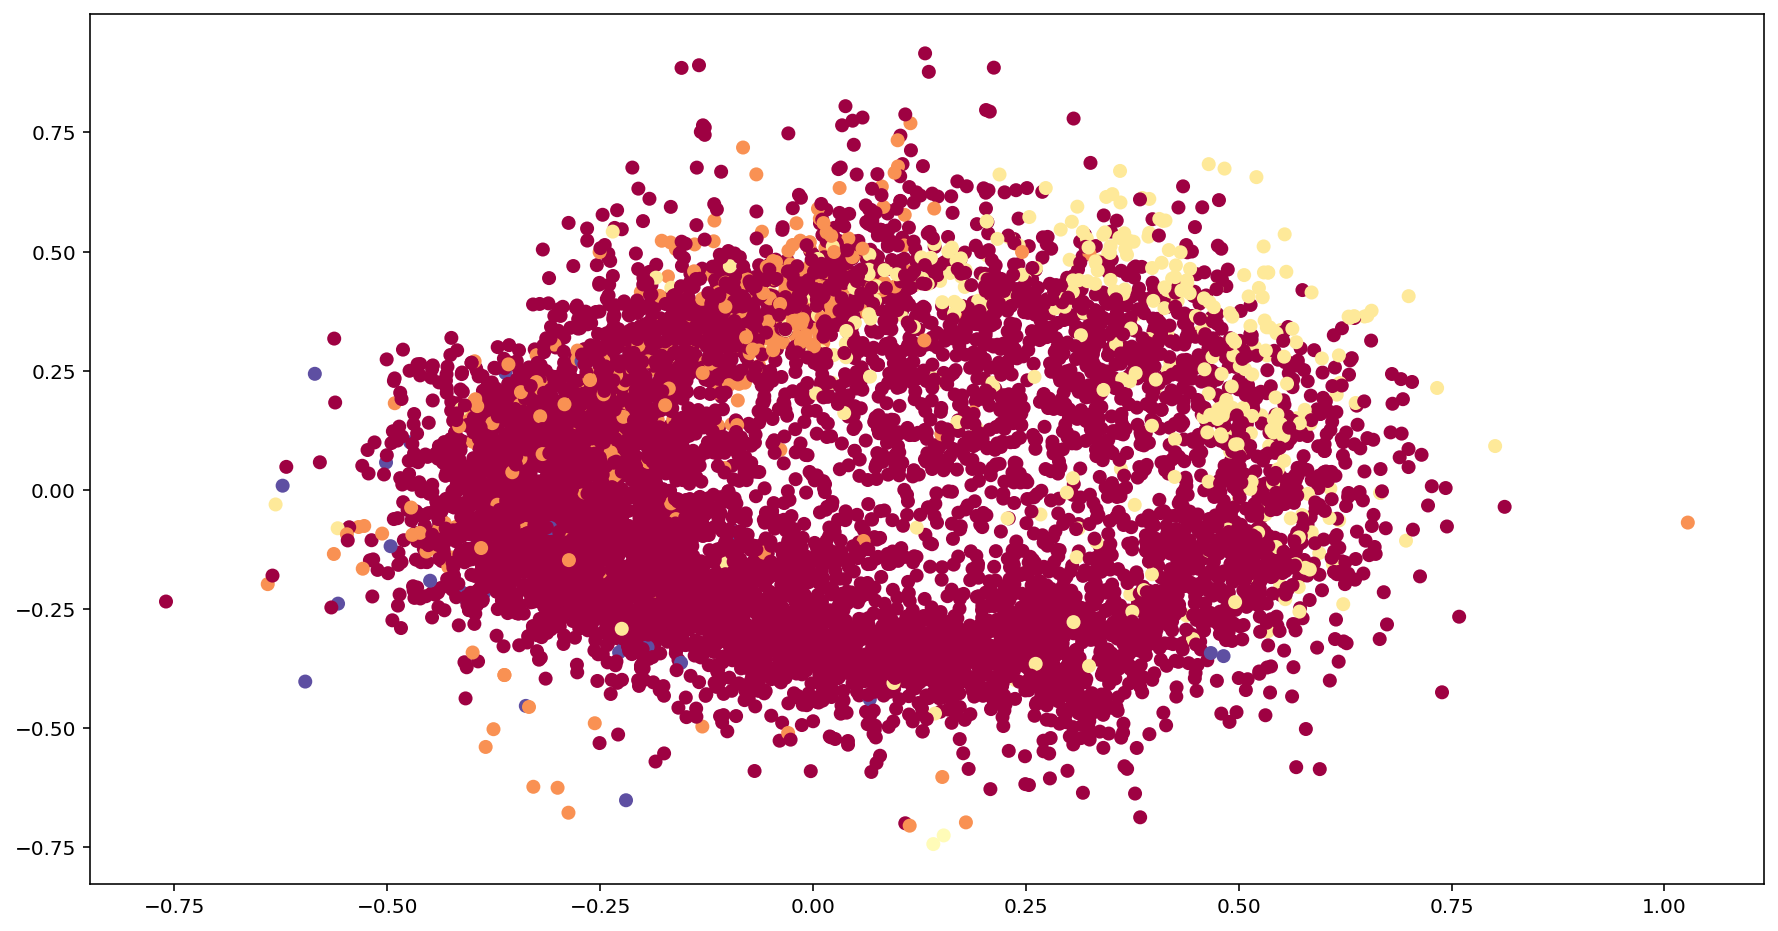

<Figure size 432x288 with 0 Axes>

<Figure size 576x576 with 0 Axes>

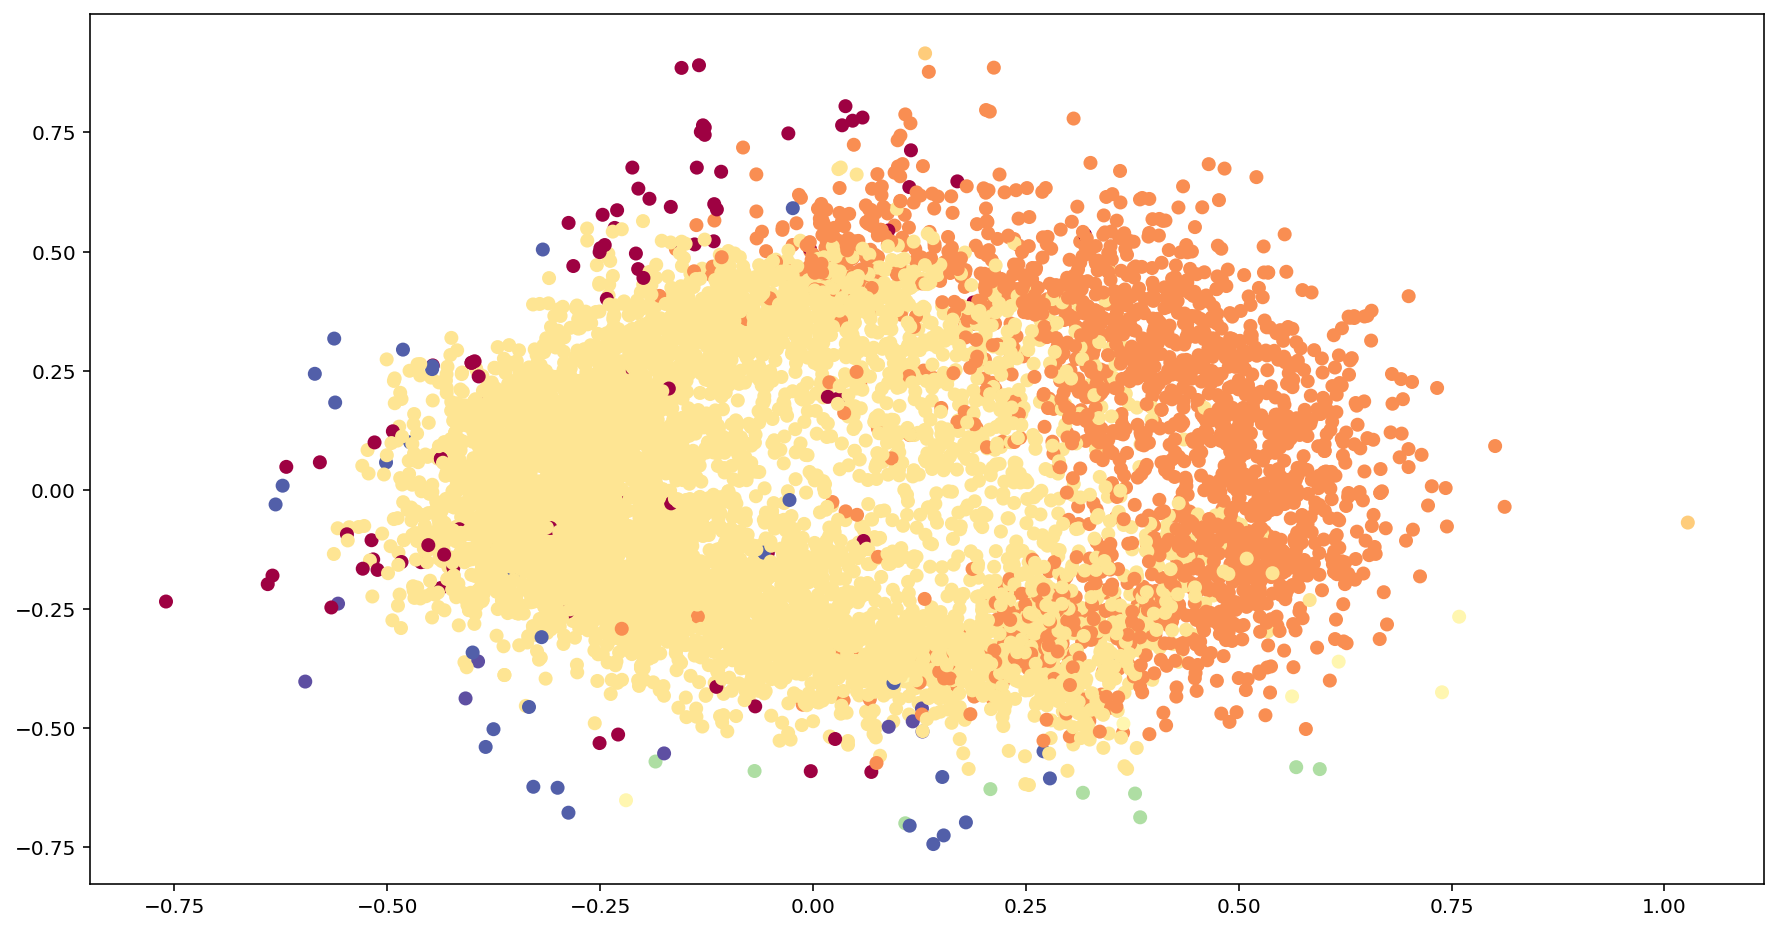

<Figure size 432x288 with 0 Axes>

<Figure size 576x576 with 0 Axes>

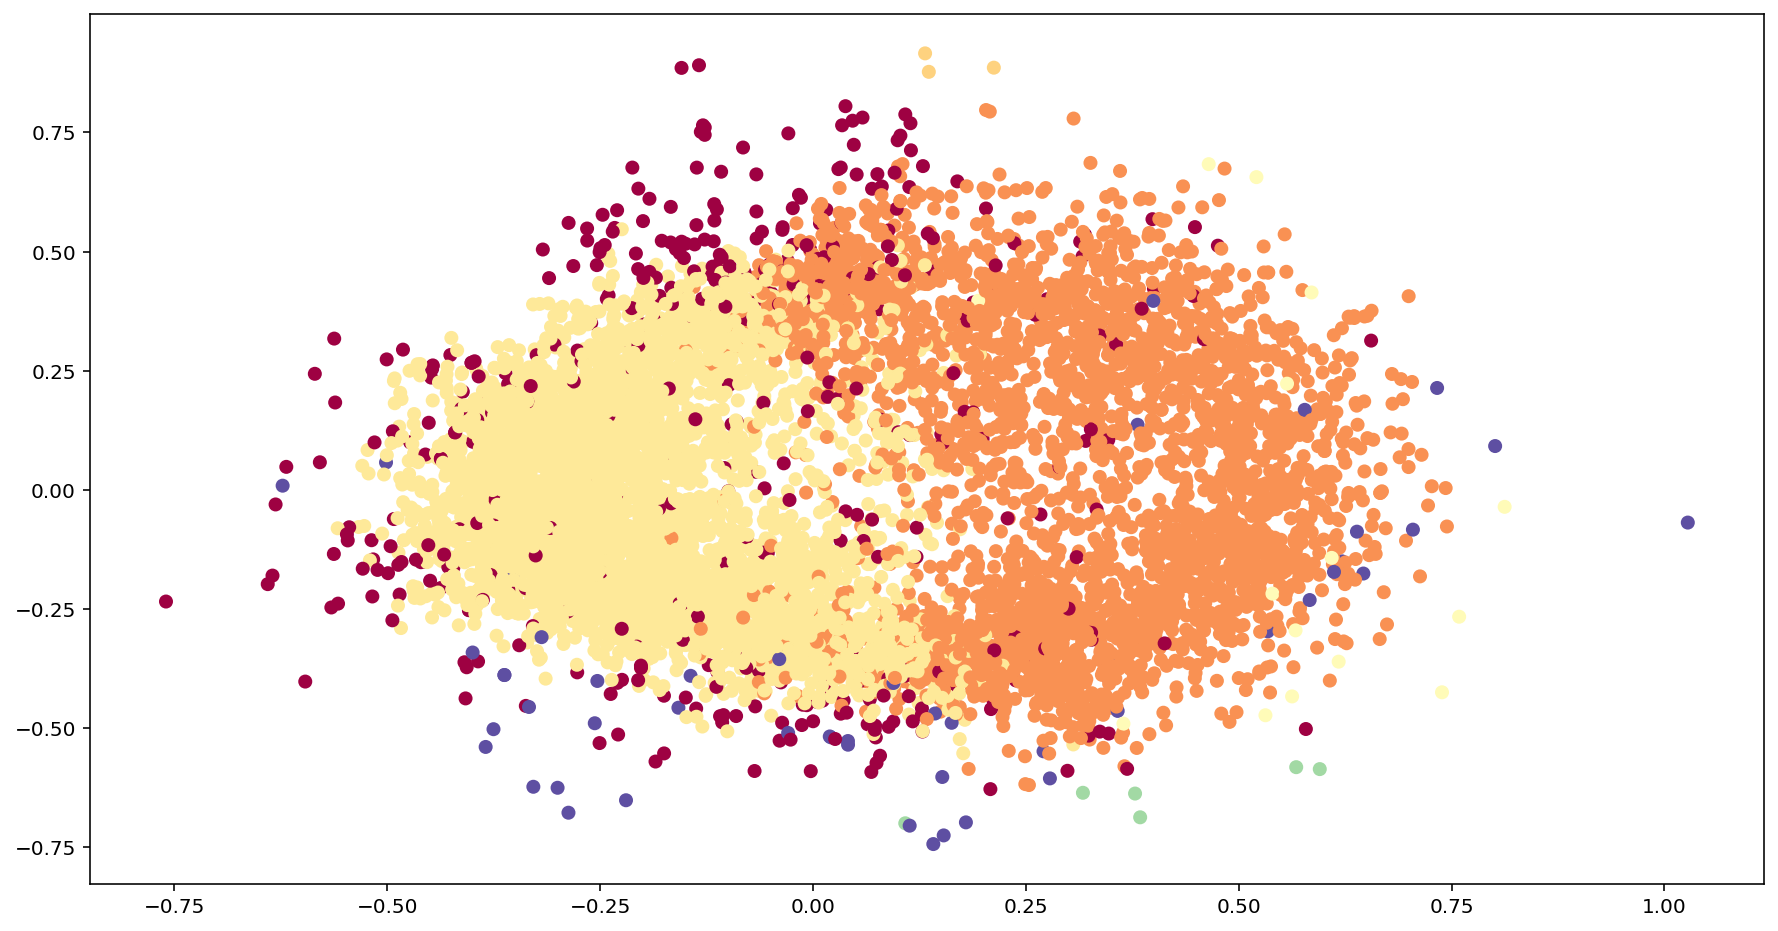

<Figure size 432x288 with 0 Axes>

<Figure size 576x576 with 0 Axes>

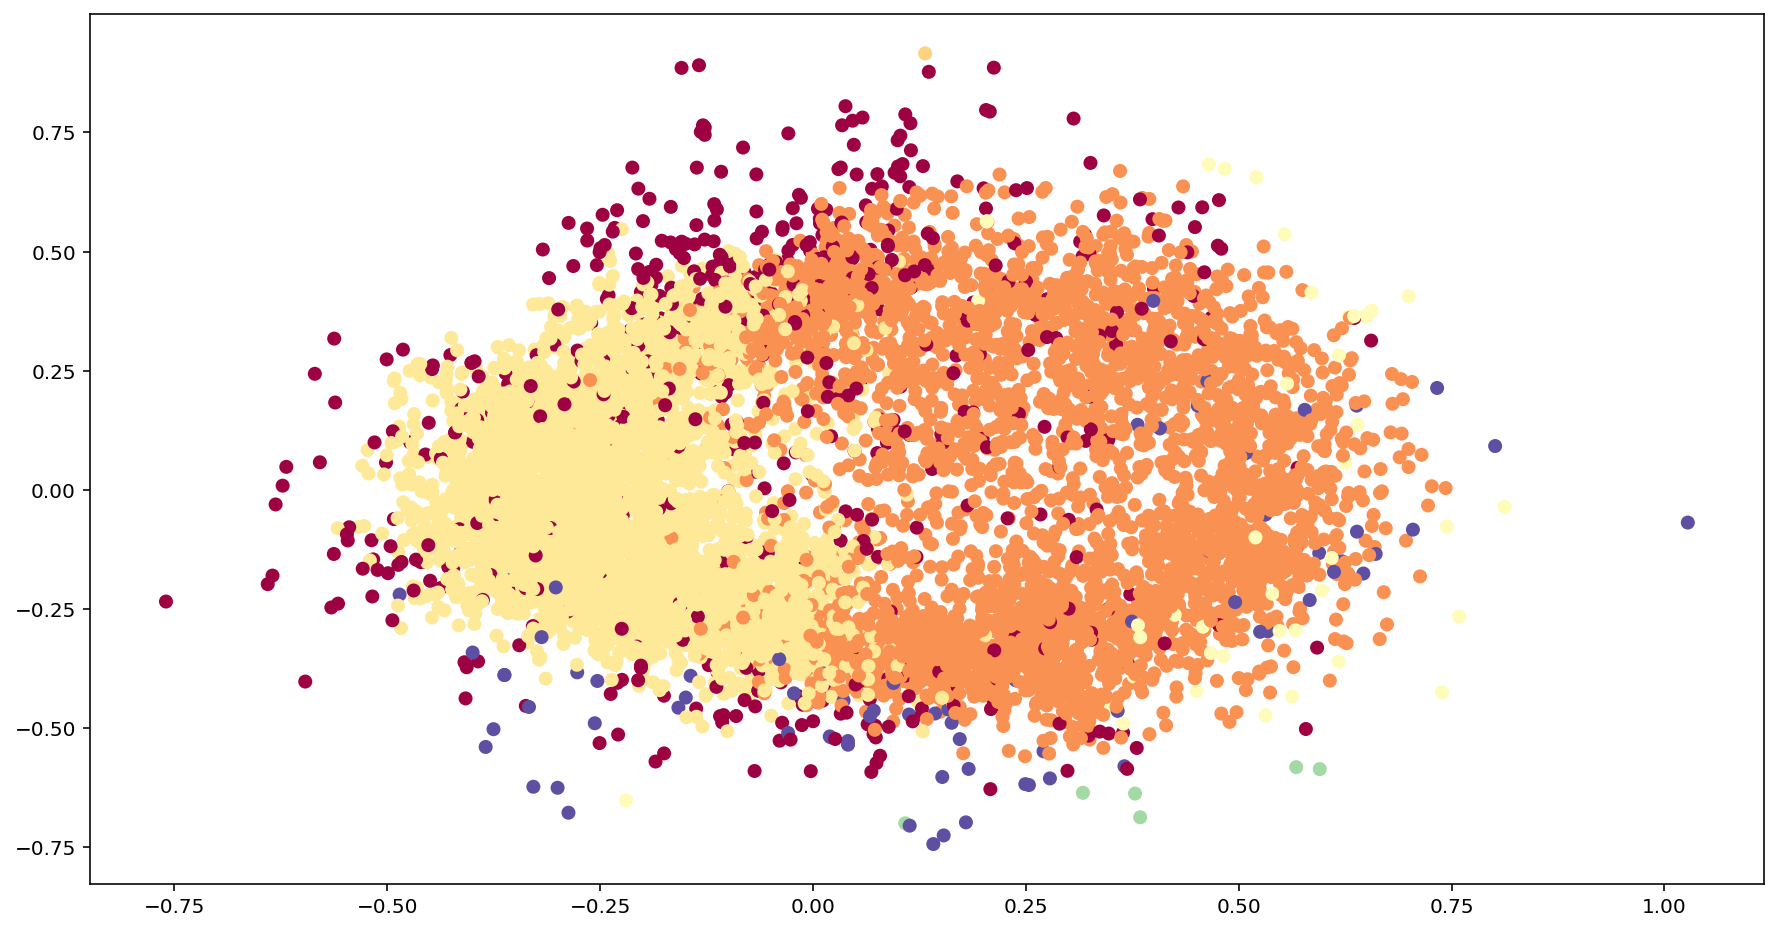

<Figure size 432x288 with 0 Axes>

In [14]:
ITERS = 1000
NUM_CLUSTERS = 40
SPARSITY = 10
BATCH_SIZE = 3113
model = GaussianMixture(NUM_CLUSTERS, sparsity=SPARSITY, D=data.shape[1])
optimizer = torch.optim.Adam(model.parameters(), lr=.1)
scheduler =  torch.optim.lr_scheduler.MultiStepLR(optimizer, [200])
loss = np.zeros(ITERS)


for it in range(ITERS):
    cost = 0
    optimizer.zero_grad()  # Reset the gradients (PyTorch syntax...).

    for i in range(int(data.shape[0] / BATCH_SIZE)):
      cost += model.neglog_likelihood(data[BATCH_SIZE * i: BATCH_SIZE * (i+1)])  # Cost to minimize.

    cost.backward()  # Backpropagate to compute the gradient.
    optimizer.step()
    scheduler.step()
    loss[it] = cost.data.cpu().numpy()
    
    if it in [0, 10, 100, 500, 999]:
        plt.pause(.01)
        plt.figure(figsize=(8,8))
        model.plot_clusters(data[::10])
        # plt.title('Density, iteration ' + str(it), fontsize=20)
        # plt.axis("equal")  ; plt.axis([0,1,0,1])
        plt.tight_layout()
        plt.pause(.01)

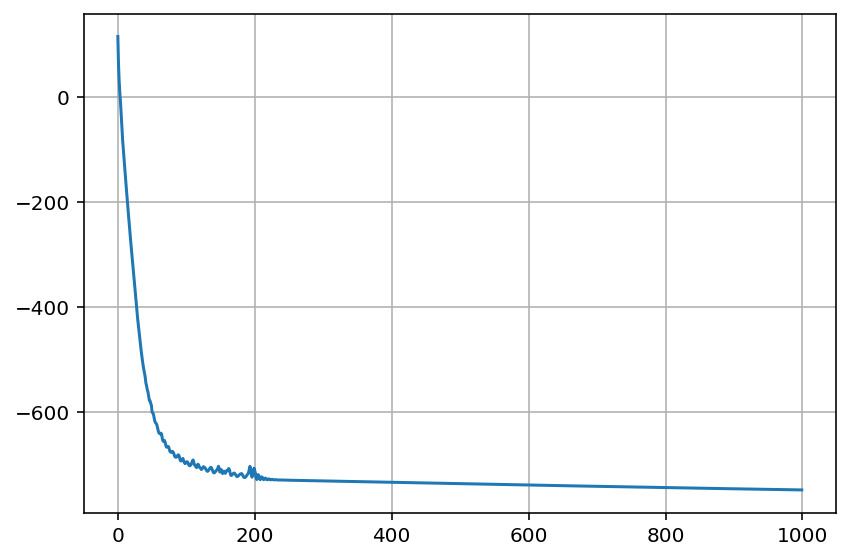

In [15]:
plt.figure()
plt.plot(loss)
plt.tight_layout()
plt.grid()
plt.show()

In [17]:
model.plot_clusters(data[::10], 3)

<Figure size 1080x576 with 0 Axes>